In [202]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [203]:
csv_path = 'datasets_56102_107707_monthly-beer-production-in-austr.csv'

df = pd.read_csv(csv_path, parse_dates=['Month'], index_col='Month')

print('Columns: ', list(df.columns))
print(df.info)

Columns:  ['Monthly beer production']
<bound method DataFrame.info of             Monthly beer production
Month                              
1956-01-01                     93.2
1956-02-01                     96.0
1956-03-01                     95.2
1956-04-01                     77.1
1956-05-01                     70.9
...                             ...
1995-04-01                    127.0
1995-05-01                    151.0
1995-06-01                    130.0
1995-07-01                    119.0
1995-08-01                    153.0

[476 rows x 1 columns]>


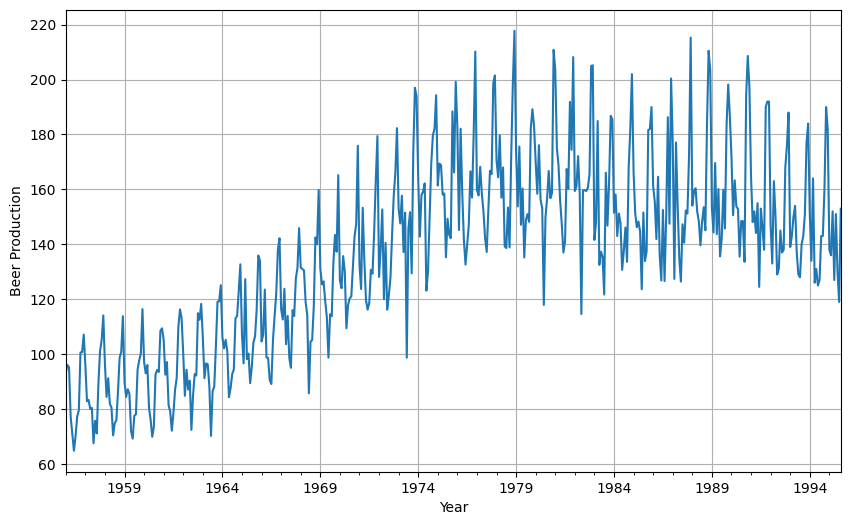

In [204]:
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Beer Production')
ax.grid(True)
ax.get_legend().remove()
plt.show()

In [205]:
# Check for missing months
idx = df.index
is_datetime = isinstance(idx, pd.DatetimeIndex)
has_duplicates = idx.duplicated().any()
inferred_freq = pd.infer_freq(idx)
if is_datetime:
    expected = pd.date_range(start=idx.min(), end=idx.max(), freq='MS')
    missing = expected.difference(idx)
    print('Number of missing months:', len(missing))

print('Index is DateTimeIndex:', is_datetime)
print('Index has duplicate timestamps:', has_duplicates)
print('Inferred frequency:', inferred_freq)

Number of missing months: 0
Index is DateTimeIndex: True
Index has duplicate timestamps: False
Inferred frequency: MS


Temporary MS copy missing points: 0
Corr(12-month rolling mean, 12-month rolling std): 0.856509228671367


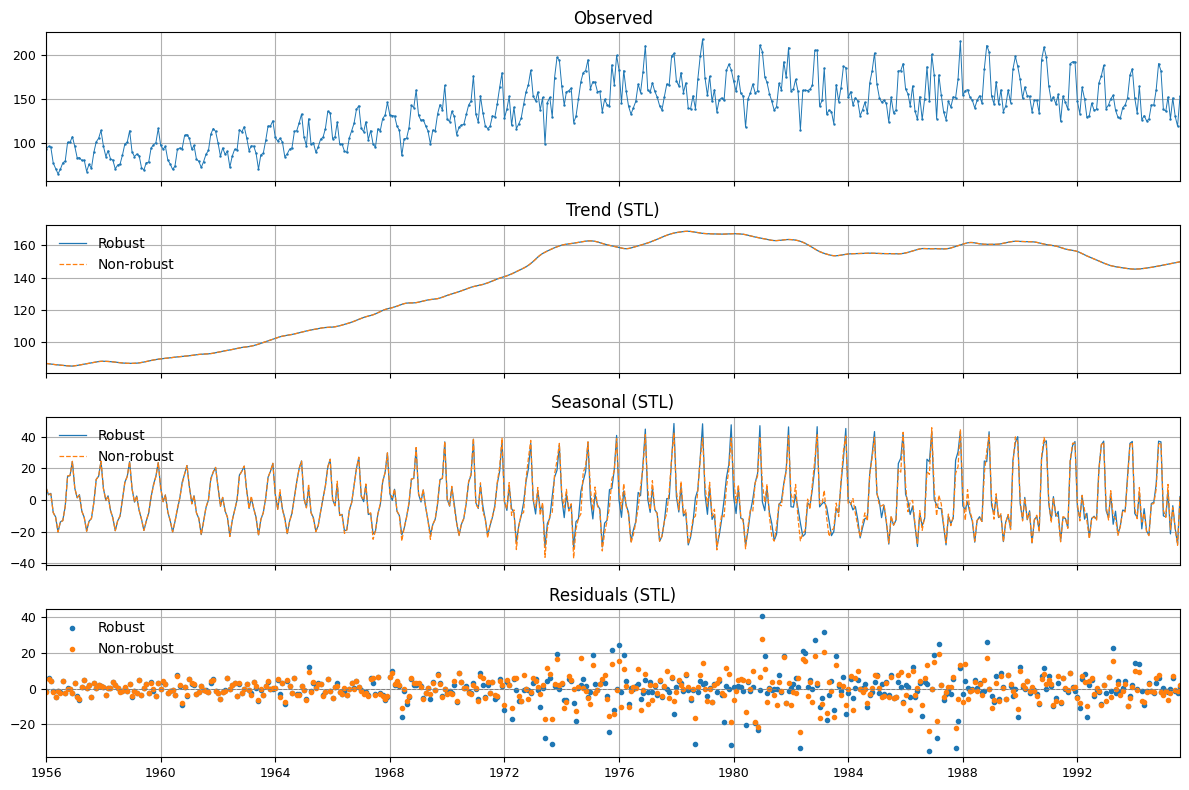

In [206]:
colname = df.columns[0]
series = df[colname]

series_ms = series.copy().asfreq('MS')
n_missing_for_decomp = int(series_ms.isna().sum())
print('Temporary MS copy missing points:', n_missing_for_decomp)

series_for_decomp = series_ms.interpolate(method='time')

# Check if seasonal amplitude grows with level
rm = series_for_decomp.rolling(window=12).mean().dropna()
rs = series_for_decomp.rolling(window=12).std().dropna()
corr_rm_rs = rm.corr(rs)
print('Corr(12-month rolling mean, 12-month rolling std):', corr_rm_rs)

# STL, period = 12, robust and non-robust
stl_robust = STL(series_for_decomp, period=12, robust=True)
res_robust = stl_robust.fit()

stl_non = STL(series_for_decomp, period=12, robust=False)
res_non = stl_non.fit()

obs = series_for_decomp
trend_r = res_robust.trend
trend_n = res_non.trend
season_r = res_robust.seasonal
season_n = res_non.seasonal
resid_r = res_robust.resid
resid_n = res_non.resid

# Plotting styles
lw = 0.9
ms = 3
obs_lw = 0.7

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
xmin, xmax = obs.index.min(), obs.index.max()

# Observed
axes[0].plot(obs.index, obs.values, linestyle='-', linewidth=obs_lw, marker='.', markersize=1.5, label='Observed')
axes[0].set_title('Observed')
axes[0].set_xlim(xmin, xmax)

# Trend
axes[1].plot(trend_r.index, trend_r.values, label='Robust', linewidth=lw, linestyle='-')
axes[1].plot(trend_n.index, trend_r.values, label='Non-robust', linewidth=lw, linestyle='--')
axes[1].set_title('Trend (STL)')
axes[1].legend(frameon=False)
axes[1].set_xlim(xmin, xmax)

# Seasonal
axes[2].plot(season_r.index, season_r.values, label='Robust', linewidth=lw, linestyle='-')
axes[2].plot(season_n.index, season_n.values, label='Non-robust', linewidth=lw, linestyle='--')
axes[2].set_title('Seasonal (STL)')
axes[2].legend(frameon=False)
axes[2].set_xlim(xmin, xmax)

# Residuals
axes[3].plot(resid_r.index, resid_r.values, linestyle='none', marker='o', markersize=ms, label='Robust')
axes[3].plot(resid_n.index, resid_n.values, linestyle='none', marker='o', markersize=ms, label='Non-robust')
axes[3].axhline(0, color='gray', linewidth=0.7, linestyle='--')
axes[3].set_title('Residuals (STL)')
axes[3].legend(frameon=False)
axes[3].set_xlim(xmin, xmax)

for ax in axes:
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout()
plt.show()

Trend: start 87.05, end 149.73, meand 136.76


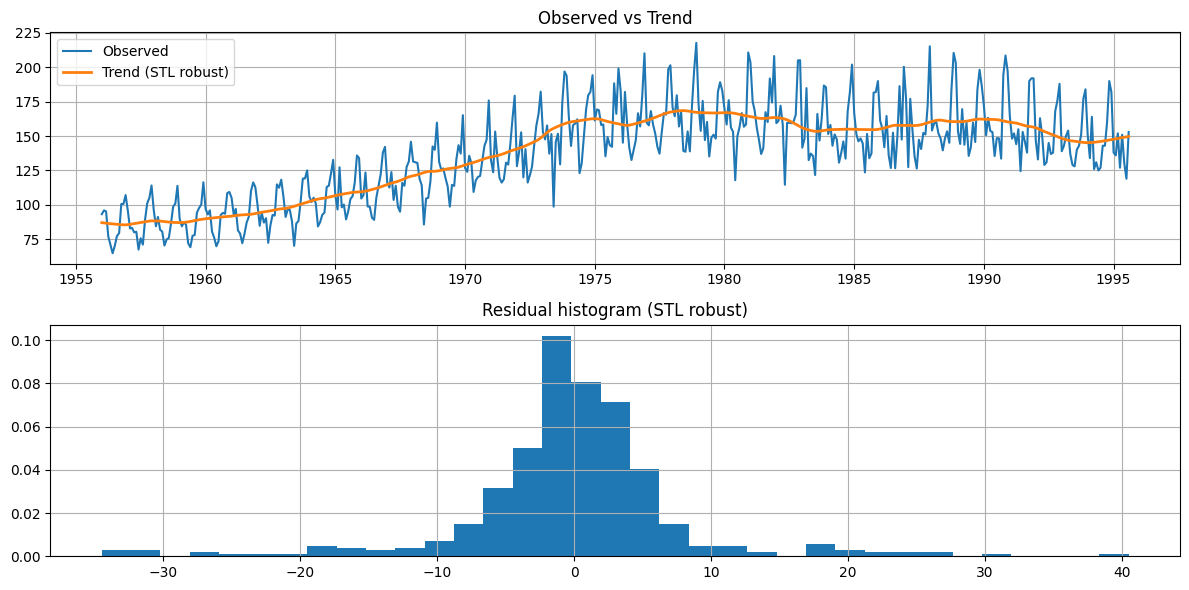

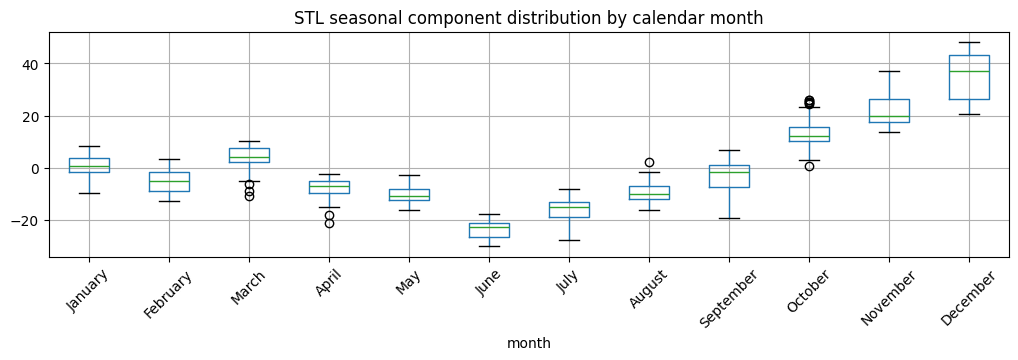

In [207]:
trend = res_robust.trend
seasonal = res_robust.seasonal
resid = res_robust.resid

print("Trend: start {:.2f}, end {:.2f}, meand {:.2f}".format(trend.dropna().iloc[0],
                                                              trend.dropna().iloc[-1],
                                                              trend.mean()))
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(series_for_decomp.index, series_for_decomp.values, label='Observed', linestyle='-')
ax[0].plot(trend.index, trend.values, label='Trend (STL robust)', linewidth=2)
ax[0].set_title('Observed vs Trend')
ax[0].legend()
ax[0].grid(True)

ax[1].hist(resid.dropna(), bins=35, density=True)
ax[1].set_title('Residual histogram (STL robust)')
ax[1].grid(True)

plt.tight_layout()
plt.show()

season_df = seasonal.to_frame(name='seasonal').copy()
season_df['month'] = season_df.index.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
season_df['month'] = pd.Categorical(season_df['month'], categories=month_order, ordered=True)

fig, ax = plt.subplots(figsize=(12, 3))
season_df.boxplot(column='seasonal', by='month', ax=ax)
ax.set_title('STL seasonal component distribution by calendar month')
plt.suptitle('')
plt.xticks(rotation=45)
plt.show()

In [208]:
# Auto correlation
data = pd.read_csv(csv_path)
data.columns = ['Month', 'Production']
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

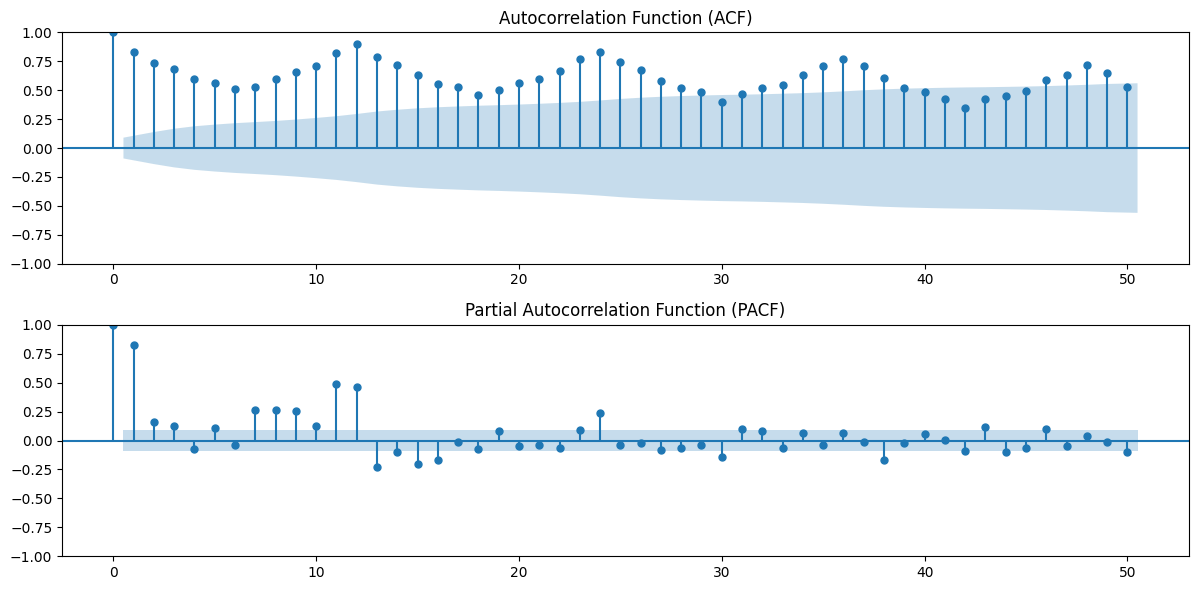

In [209]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(data['Production'], ax=ax[0], lags=50)
plot_pacf(data['Production'], ax=ax[1], lags=50)
ax[0].set_title("Autocorrelation Function (ACF)")
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()